# AutoEncoder

## Importing necessary libraries

In [116]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

## Seeding for reproducibility

In [114]:
np.random.seed(421)
torch.random.manual_seed(421)

## Dataset Loading

In [115]:
batch_size = 64
data_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
train_dataset = datasets.MNIST(root='MNIST_AE', download=True, train=True, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_dataset = datasets.MNIST(root='MNIST_AE', download=True, train=False, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=2)

## AutoEncoder Class

In [127]:
class ConvAE(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.convtranspose1 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.convtranspose2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        

    def forward(self,x):
        x = self.relu(self.pool1(self.conv1(x)))
        x = self.relu(self.pool1(self.conv2(x)))
        x = self.relu(self.convtranspose1(x))
        x = self.tanh(self.convtranspose2(x))
        return x

## Hyperparameters

In [128]:
#Config 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:',device)
device = torch.device(device)
num_epoch = 5
lr = 2e-4

Device: cuda


## Model instance

In [129]:
images,labels=next(iter(train_loader))
model = ConvAE().to(device)

## Loss function and Optimizer

In [130]:
#Loss and Optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


## Training Loop

In [131]:
#Training
model.train()
for epoch in range(num_epoch):
    total_loss = 0
    for (images,_) in train_loader:
        images = images.to(device)
        preds = model(images)
        loss = criterion(preds, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch:[{epoch}/{num_epoch}], Reconstruction Loss:{total_loss/len(train_loader)}")

Epoch:[0/5], Reconstruction Loss:0.2151690826757249
Epoch:[1/5], Reconstruction Loss:0.043440066994841035
Epoch:[2/5], Reconstruction Loss:0.03060205963287336
Epoch:[3/5], Reconstruction Loss:0.024388050706163525
Epoch:[4/5], Reconstruction Loss:0.02076368119472316


## Helper functions- Plotting 

In [52]:
def plot_images(image_grid,title):
    plt.figure(figsize=(8, 2))
    plt.imshow(image_grid,cmap='gray')
    plt.title(title)

def reshape_images(images):
    #images = torch.stack([image.reshape(1,28,28) for image in images])
    return torch.cat([tensor for tensor in images],dim=2)

## Model Evaluation

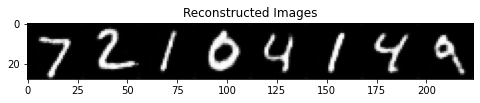

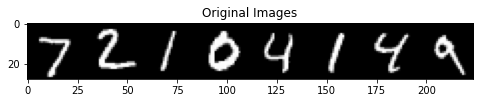

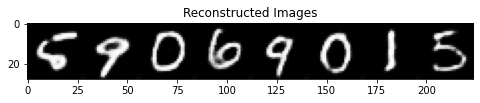

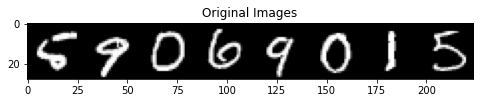

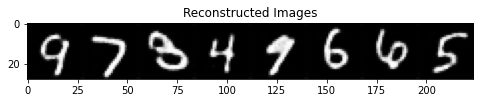

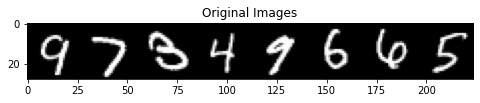

In [136]:
model.eval()
with torch.no_grad():
    for idx,(images,_) in enumerate(test_loader):
            images = images.to(device)
            preds = model(images)
            images = reshape_images(images)*0.5 + 0.5
            preds = reshape_images(preds)*0.5 + 0.5

            plot_images(preds[0].cpu(),'Reconstructed Images')
            plot_images(images[0].cpu(),'Original Images')

            if idx == 2:
                break
        

## Hook function

In [149]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## Forward Hook activations

In [150]:
model.convtranspose2.register_forward_hook(get_activation('convtranspose2'))
print(activation)
images,_ = next(iter(test_loader))
images = images.to(device)
output = model(images)

{}


## Helper plot functions

In [151]:
def plot_images_hook(image_grid,title):
    plt.figure(figsize=(8, 2))
    plt.imshow(image_grid,cmap='gray')
    plt.title(f'Activations for Conv Layer {title}')

def reshape_images_hook(images):
    #images = torch.stack([image.reshape(1,28,14) for image in images])
    return torch.cat([tensor for tensor in images],dim=2)


## Plotting activations

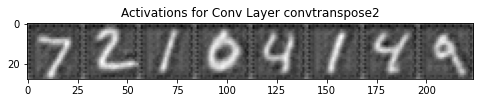

In [152]:
act = activation['convtranspose2']
act = reshape_images_hook(act)
plot_images_hook(act[0].cpu(),'convtranspose2')